In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/Text_Summarization_Task


/content/drive/My Drive/Colab Notebooks/Text_Summarization_Task


In [4]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

## **Running preprocessing Notebook to use it's functions**

In [5]:
%run Preprocessing.ipynb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 112kB 4.9MB/s 
  Created wheel for PyArabic: filename=PyArabic-0.6.7-cp36-none-any.whl size=108603 sha256=8c144eb38191c00fbd6c42127b7bfe2c3d610258a5bbca5d0b2d6268972643f1
  Stored in directory: /root/.cache/pip/wheels/c6/50/b1/4df7f705f36e91360ab04416dbf1017084698d30a7a3645b5e
Successfully built PyArabic
     |████████████████████████████████| 245kB 4.3MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Importing Custom attention layer**
Keras Doesn't support attention layer so I have downloaded custom attention layer from here [github](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py )

In [0]:
from attention import AttentionLayer

## **Import the Libraries**

In [7]:
import numpy as np
import pandas as pd 
import re           
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## **The Dataset**

The Dataset are News summary .The dataset has up to 98,000 news headlines and texts.

The dataset can be acquire from here: https://www.kaggle.com/sunnysai12345/news-summary

In [0]:
#data_more = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Text_Summarization_Task/Datasets/news_summary.csv" , encoding = "ISO-8859-1" )
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Text_Summarization_Task/Datasets/news_summary_more.csv")

In [9]:
data.columns


Index(['headlines', 'text'], dtype='object')

### **Drop Duplicates and NA values**

In [0]:
data.drop_duplicates(subset=['text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [11]:
len(data)

98360

## **Preprocessing**

We are going to use functions from the proprocessing notebook on the data here.  
For details about the functions check the notebook
but in short we are doing here to text and headlines is the following:
*   Convert everything to lowercase
*   Contraction mapping
*   Eliminate punctuations and special characters
*   Remove stopwords


### **Text Cleaning**

In [0]:
cleaned_text = []
for t in data['text']:
    cleaned_text.append(preprocess(t , stemming = False , rm_short = True))

In [0]:
## Remove extra whitespace
for i in range(len(cleaned_text)):
  cleaned_text[i] = re.sub('\s+', ' ', cleaned_text[i])

In [14]:
cleaned_text[:10]

['saurav kant alumnus upgrad iiit program machine learning artificial intelligence systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesse

### **headlines cleaning**

In [0]:
cleaned_summary = []
for t in data['headlines']:
    cleaned_summary.append(preprocess(t , stemming = False))

In [0]:
## Remove extra whitespace
for i in range(len(cleaned_summary)):
  cleaned_summary[i] = re.sub('\s+', ' ', cleaned_summary[i])

In [17]:
cleaned_summary[:10]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india s match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam',
 'rahat fateh ali khan denies getting notice smuggling currency',
 'india get lowest odi total new zealand',
 'govt directs alok verma join work day retirement',
 'called pm modi sir times satisfy ego andhra cm',
 'cong wins ramgarh bypoll rajasthan takes total seats']

### **Changing orignal data**

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### **Applying start and End tokens in the summary**

In [19]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: saurav kant alumnus upgrad iiit program machine learning artificial intelligence systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
Summary: _START_ upgrad learner switches career ml al salary hike _END_


Review: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit
Summary: _START_ delhi techie wins free food swiggy one year cred _END_


Review: new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
Summary: _

## **Understanding the distribution of the sequences**

We can get plot the length of setences in texts or summary to get an idea about how long most of the data

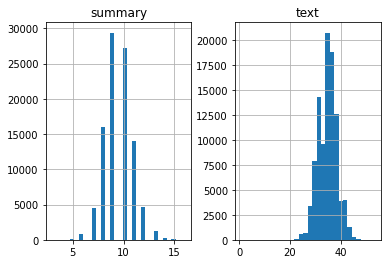

In [20]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

we Can deduce that most of the Summary are less than 10 words and Texts are less than 80.  
We can use this information to fix the maximum size of both.

In [0]:
max_len_text=50
max_len_summary=15

## **Splitting Dataset**

Now let's split data into training and validations sets. The ratios will be 90% training to 10% validation. this is easily done using sktlearn library 

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

## **Preparing the Tokenizer**

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

### **Text Tokenizer**

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

### **Summary Tokenizer**

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

## **Model Building**

The Model consists of:

* 3 stacked LSTM for the encoder.
* Attnetion Model.
* LSTM for the decoder. 
* Dense Layer



In [25]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 500)      36625500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## **Compiling And early Stopping**

Using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

Early stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases.

We’ll train the model on a batch size of 512 and validate it on the holdout set (which is 10% of our dataset)

In [26]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy' , metrics = 'accuracy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/20
173/173 [==============================] - 151s 873ms/step - loss: 4.7425 - accuracy: 0.4592 - val_loss: 4.2612 - val_accuracy: 0.4883
Epoch 2/20
173/173 [==============================] - 149s 861ms/step - loss: 4.1601 - accuracy: 0.4869 - val_loss: 3.8961 - val_accuracy: 0.5006
Epoch 3/20
173/173 [==============================] - 149s 861ms/step - loss: 3.7386 - accuracy: 0.5066 - val_loss: 3.5672 - val_accuracy: 0.5230
Epoch 4/20
173/173 [==============================] - 149s 864ms/step - loss: 3.4050 - accuracy: 0.5274 - val_loss: 3.3657 - val_accuracy: 0.5384
Epoch 5/20
173/173 [==============================] - 149s 862ms/step - loss: 3.1394 - accuracy: 0.5457 - val_loss: 3.2261 - val_accuracy: 0.5500
Epoch 6/20
173/173 [==============================] - 149s 862ms/step - loss: 2.9108 - accuracy: 0.5626 - val_loss: 3.1489 - val_accuracy: 0.5555
Epoch 7/20
173/173 [==============================] - 149s 862ms/step - loss: 2.7055 - accuracy: 0.5782 - val_loss: 3.0831 -

## **Understanding the Diagnostic plot**

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

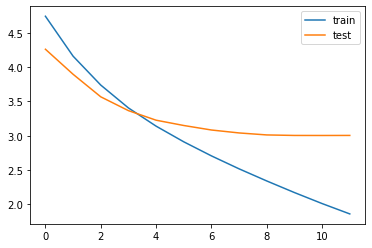

In [27]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

Next, build the dictionary to convert the index to word for target and source vocabulary.

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

## **Inference**

Set up the inference for the encoder and decoder:

In [0]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

## **Convert an integer sequence to a word sequence**

functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

## **Generating Output**

Generate 20 summeries from the validation set

In [32]:
for i in range(20):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: gangster chhota rajan brother booked raping woman multiple times farmhouse maharashtra panvel police said deepak sadashiv provided financial aid victim education allegedly raped several times got pregnant reportedly made abort baby promising get married 
Original summary: gangster chhota rajan s brother booked raping woman 
Predicted summary:  man accused raping woman rape noida


Review: bombay high court thursday told maharashtra government dictator government arbitrarily revoked allotment square metre plot christian cemetery goregaon court hearing pil filed charitable christian organisation complained lack cemeteries large section christians 
Original summary: dictator bombay hc maha government 
Predicted summary:  maha govt asks maha govt release bombay hc


Review: ahead raymond meeting consider sale house promoters extended family chairman gautam singhania said personal opinion would vote resolution earlier proxy advisory firm iias slammed proposal saying raymond promoter